# Modeling
This notebook shows how I trained the model I use in my Ile-de-France rent prediction [app](http://www.nicolascontreras.tech/portfolio/rent_pred).

# 1. Imports

In [33]:
import numpy as np
import pandas as pd
import os

from tensorflow.keras import layers
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras import backend as K

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from pickle import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

# 2. Read data

In [55]:
filepath = os.path.join('data', 'locations_2020_10_clean.csv')
df = pd.read_csv(filepath, sep='|')

# Bin rooms & bedrooms and encode them
df.loc[df.rooms >= 5, 'rooms'] = '≥5'
df.rooms = df.rooms.astype('category').cat.codes
df.loc[df.bedrooms >= 3, 'bedrooms'] = '≥3'
df.bedrooms = df.bedrooms.astype('category').cat.codes

df.head()

,price,is_house,surface,rooms,bedrooms,furnished,dept,lat,lon
0,549,0,14.21,0,0,0,93,48.868739,2.460985
1,897,0,40.64,1,1,0,93,48.926655,2.475222
2,834,0,28.00,0,0,0,92,48.812341,2.315574
3,1200,0,48.00,2,2,0,92,48.812341,2.315574
4,2400,0,98.18,3,3,1,92,48.885948,2.210607


# 3. Define modeling and plotting functions

In [56]:
def split_data(df, catcols, dropcols, random_state=None):
    
    X = df.drop(['price'], axis=1)
    for col in catcols:
        X[col] = X[col].astype('category').cat.codes
    y = df.filter(['price'], axis=1)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                        stratify=X.dept, random_state=random_state)

    X_train = X_train.drop(dropcols, axis=1)
    X_test = X_test.drop(dropcols, axis=1)
    X = X.drop(dropcols, axis=1)
    
    numcols = X.drop(catcols, axis=1).columns
    
    scaler = RobustScaler()
    
    X_train = pd.concat([
        pd.DataFrame(scaler.fit_transform(X_train.drop(catcols, axis=1)), columns=numcols),
        X_train[catcols].reset_index(drop=True)
    ], axis=1)
    
    X_test = pd.concat([
        pd.DataFrame(scaler.transform(X_test.drop(catcols, axis=1)), columns=numcols),
        X_test[catcols].reset_index(drop=True)
    ], axis=1)
    
    return scaler, X, X_train, X_test, y_train, y_test

In [57]:
def make_model(X, catcols):
    
    def r_square(y_true, y_pred):
        SS_res =  K.sum(K.square( y_true-y_pred )) 
        SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
        return ( 1 - SS_res/(SS_tot + K.epsilon()) )
    
    numcols = [col for col in X.columns if col not in catcols]
    
    inputs = []
    outputs = []
    
    for col in catcols:
        nunique = X[col].nunique()
        inp = layers.Input(shape=(1,), name=col)
        h = layers.Embedding(nunique + 1, 32)(inp)
        h = layers.SpatialDropout1D(.3)(h)
        out = layers.Reshape(target_shape=(32,))(h)
        inputs.append(inp)
        outputs.append(out)
    
    num_input = layers.Input(shape=(len(numcols),), name='numcols')
    inputs.append(num_input)
    outputs.append(num_input)
    
    h = layers.Concatenate()(outputs)

    h = layers.Dense(96, activation='relu')(h)
    h = layers.BatchNormalization()(h)
    h = layers.Dropout(.3)(h)

    h = layers.Dense(48, activation='relu')(h)
    h = layers.BatchNormalization()(h)
    h = layers.Dropout(.3)(h)

    outputs = layers.Dense(1, activation='linear')(h)
    
    model = Model(inputs=inputs, outputs=outputs)    
    model.compile(optimizer=Adam(.005), loss='mean_squared_error', metrics=[r_square])
    
    return model

In [58]:
def fit_model(df, catcols, dropcols, random_state):
    scaler, X, X_train, X_test, y_train, y_test = split_data(df, catcols, dropcols, random_state)

    model = make_model(X, catcols)
    
    inputs_train = {
        col: X_train[col]
        for col in catcols
    }
    inputs_train['numcols'] = X_train.loc[:, [col for col in X_train.columns if col not in catcols]]
    
    inputs_test = {
        col: X_test[col]
        for col in catcols
    }
    inputs_test['numcols'] = X_test.loc[:, [col for col in X_test.columns if col not in catcols]]

    callbacks = [EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
                 ReduceLROnPlateau(monitor='val_loss', patience=15, factor=.5)]
    history = model.fit(inputs_train, y_train, validation_data=(inputs_test, y_test),
                        epochs=500, batch_size=32, callbacks=callbacks)
    
    return model, history, inputs_train, y_train, inputs_test, y_test, scaler

In [59]:
def style_plot(legend=False, bottom=False):
    sns.despine(left=True, bottom=bottom)
    plt.grid(True, axis='y', **{'color': 'darkgray', 'linestyle': ':'})
    plt.tick_params(left=False, bottom=False)
    plt.yticks(**{'color': 'k', 'alpha': .5, 'fontsize': 14})
    plt.xticks(**{'fontsize': 14})
    if legend:
        plt.legend(frameon=True, framealpha=1, facecolor='white', edgecolor='white', fontsize=14)

def plot_history(history):
    plt.figure(figsize=(20, 12))

    plt.subplot(311)
    plt.plot(history['lr'])
    plt.title('Learning rate vs Epochs', size=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Learning rate', fontsize=14, **{'color': 'k', 'alpha': .5})
    style_plot()

    plt.subplot(223)
    plt.plot(history['loss'], label='Train loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.title('Loss vs Epochs', size=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14, **{'color': 'k', 'alpha': .5})
    style_plot(True)

    plt.subplot(224)
    plt.plot(history['r_square'], label='Train R-squared')
    plt.plot(history['val_r_square'], label='Validation R-squared')
    plt.title('Loss vs Epochs', size=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('R-squared', fontsize=14, **{'color': 'k', 'alpha': .5})
    style_plot(True)

    plt.show()
    
def plot_actual_vs_predicted(model, inputs_train, inputs_test, y_train, y_test):
    plt.figure(figsize=(20, 6))
    plt.suptitle('Actual vs predicted monthly rents (in €)', size=16)

    plt.subplot(121)

    y_train = y_train.reset_index(drop=True)
    y_train.loc[:, 'predicted_price'] = model.predict(inputs_train)
    y_train.sort_values('price').reset_index(drop=True).price.plot(kind='line', label='actual rent')
    y_train.sort_values('price').reset_index(drop=True).predicted_price.plot(kind='line',
                                                                             alpha=.5, label='predicted rent')
    plt.title('Train set', size=14)
    plt.xticks([])
    style_plot(True, True)

    plt.subplot(122)
    y_test = y_test.reset_index(drop=True)
    y_test.loc[:, 'predicted_price'] = model.predict(inputs_test)
    y_test.sort_values('price').reset_index(drop=True).price.plot(kind='line', label='actual rent')
    y_test.sort_values('price').reset_index(drop=True).predicted_price.plot(kind='line',
                                                                            alpha=.5, label='predicted rent')
    plt.title('Test set', size=14)
    plt.xticks([])
    style_plot(True, True)

    plt.show()

# 4. Train model

In [60]:
catcols = ['rooms', 'bedrooms', 'is_house', 'furnished']
dropcols = ['dept']
model, history, inputs_train, y_train, inputs_test, y_test, scaler = fit_model(df, catcols, dropcols, 0)

Epoch 1/500
52/52 [==============================] - 0s 7ms/step - loss: 1292010.1250 - r_square: -5.5440 - val_loss: 1364369.5000 - val_r_square: -4.8686
Epoch 2/500
52/52 [==============================] - 0s 4ms/step - loss: 1253139.2500 - r_square: -5.1572 - val_loss: 1382906.3750 - val_r_square: -4.9797
Epoch 3/500
52/52 [==============================] - 0s 4ms/step - loss: 1182583.8750 - r_square: -5.0986 - val_loss: 1403673.3750 - val_r_square: -5.1253
Epoch 4/500
52/52 [==============================] - 0s 4ms/step - loss: 1077830.2500 - r_square: -4.6030 - val_loss: 1371533.6250 - val_r_square: -5.0348
Epoch 5/500
52/52 [==============================] - 0s 4ms/step - loss: 955325.0625 - r_square: -3.6506 - val_loss: 1281404.2500 - val_r_square: -4.7042
Epoch 6/500
52/52 [==============================] - 0s 4ms/step - loss: 823405.6250 - r_square: -3.1531 - val_loss: 1058021.7500 - val_r_square: -3.7413
Epoch 7/500
52/52 [==============================] - 0s 4ms/step - loss:

52/52 [==============================] - 0s 4ms/step - loss: 107423.8516 - r_square: 0.6725 - val_loss: 41701.9805 - val_r_square: 0.8294
Epoch 56/500
52/52 [==============================] - 0s 4ms/step - loss: 118643.4531 - r_square: 0.6061 - val_loss: 40972.0820 - val_r_square: 0.8523
Epoch 57/500
52/52 [==============================] - 0s 4ms/step - loss: 115419.8750 - r_square: 0.6273 - val_loss: 41909.3984 - val_r_square: 0.8470
Epoch 58/500
52/52 [==============================] - 0s 4ms/step - loss: 116909.4453 - r_square: 0.6088 - val_loss: 33109.1289 - val_r_square: 0.8614
Epoch 59/500
52/52 [==============================] - 0s 4ms/step - loss: 103630.8984 - r_square: 0.6520 - val_loss: 38554.5195 - val_r_square: 0.8346
Epoch 60/500
52/52 [==============================] - 0s 4ms/step - loss: 96748.5391 - r_square: 0.6821 - val_loss: 36470.3672 - val_r_square: 0.8481
Epoch 61/500
52/52 [==============================] - 0s 4ms/step - loss: 109590.8984 - r_square: 0.6662 - v

# 5. Evaluate model performance

In [61]:
score = r2_score(y_test, model.predict(inputs_test))
print(f'R-squared = {score:.2%}')

R-squared = 89.65%


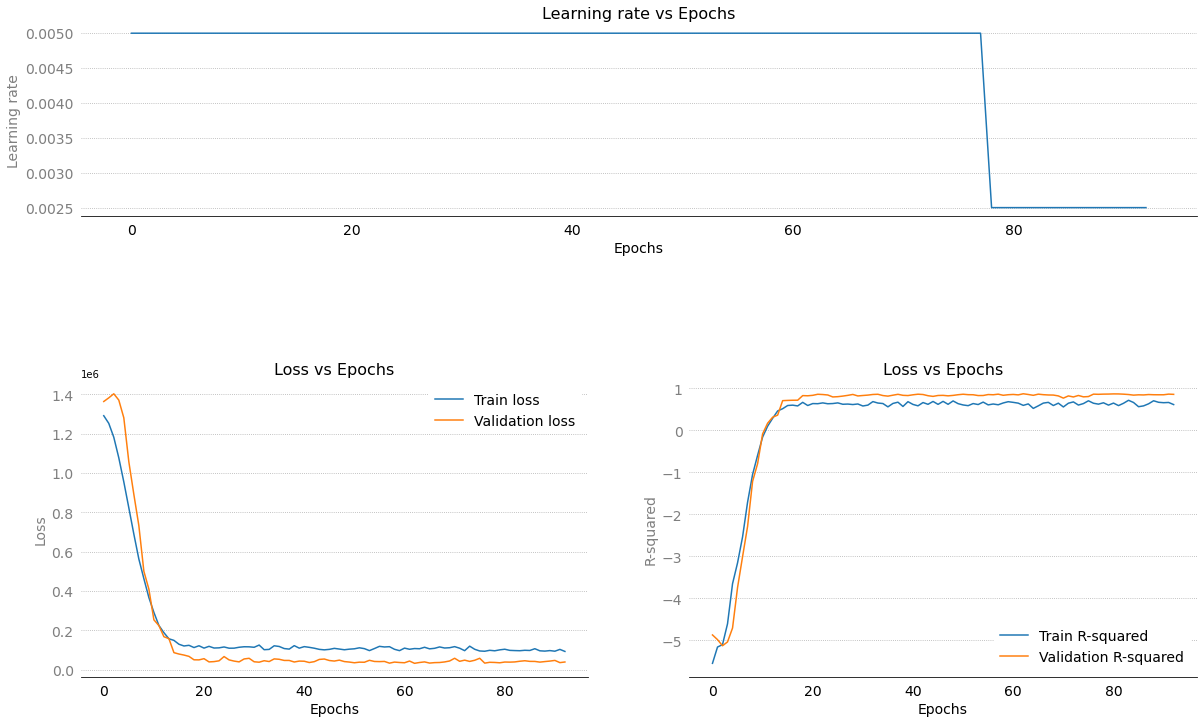

In [62]:
plot_history(history.history)

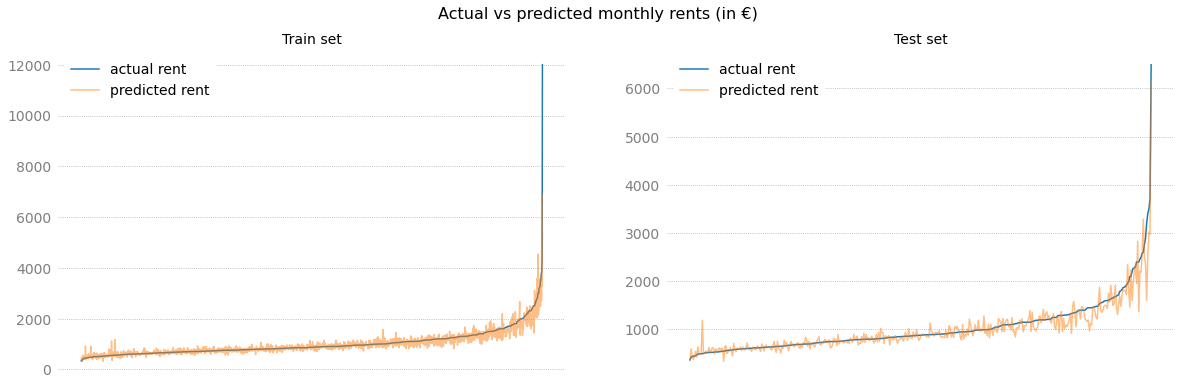

In [63]:
plot_actual_vs_predicted(model, inputs_train, inputs_test, y_train, y_test)

# 6. Save model and scaler on disk

In [51]:
# define output directory
output = 'output'
if not os.path.isdir(output):
    os.mkdir(ouptput)
    
# save model
save_model(model, os.path.join(output, 'rent_predictor.h5'))

# save medians and standard deviations used to scale data
x = scaler.inverse_transform(inputs_train['numcols'])
medians = np.quantile(x, .5, 0)
stds = x.std(0)
with open(os.path.join(output, 'scaler.pkl'), 'wb') as f:R-squared = 89.97%
    dump(np.stack([medians, stds]), f)